iter:5000 training loss: 0.00452799117192626, val loss: 0.004722251556813717
iter:10000 training loss: 0.0028974986635148525, val loss: 0.002946884138509631
iter:15000 training loss: 0.002563685178756714, val loss: 0.002641058061271906
iter:20000 training loss: 0.002465737285092473, val loss: 0.0025206655263900757
iter:25000 training loss: 0.0024363361299037933, val loss: 0.0025020602624863386
iter:30000 training loss: 0.0024126155767589808, val loss: 0.0024805618450045586
iter:35000 training loss: 0.002397022442892194, val loss: 0.002455195877701044
iter:40000 training loss: 0.002392127411440015, val loss: 0.002452793065458536
iter:45000 training loss: 0.0023845452815294266, val loss: 0.002453663619235158
iter:50000 training loss: 0.0023784744553267956, val loss: 0.002450673608109355
iter:55000 training loss: 0.0023849846329540014, val loss: 0.0024389110039919615
iter:60000 training loss: 0.002361478516831994, val loss: 0.002447177190333605
iter:65000 training loss: 0.0023698029108345

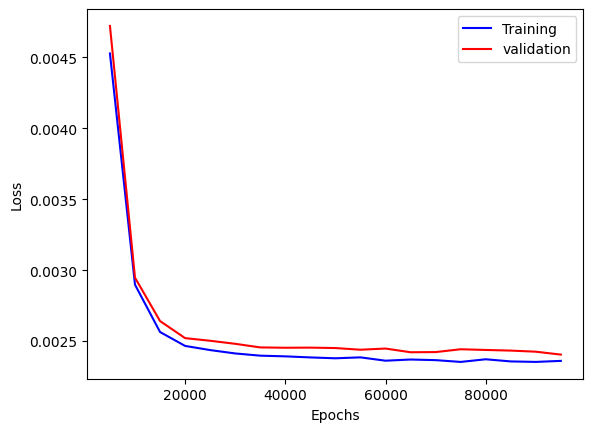

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    ## Create colormap (red to blue)
    colormap = 'RdBu_r'
    # Plot the matrix
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1, )
    fig.show()
    fig.data = ()

input_size = 20
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.1
max_iters = 100000
dataset_size = 1024
sparsity = 0.99 # appears only one in 100 times
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.7**i for i in range(input_size)])


def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    # TODO Implement mini batch
    a,b = training_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = training_dataset*sparsity_mat
    return X, X

def sample_validation_data():
    a,b = validation_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = validation_dataset*sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.layer2 = nn.Linear(hidden_layer_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, input, targets = None):
         # Input is (B,I)

        logits = self.layer1(input) # (B, dim)
        
        #logits = self.layer2(logits)
        layer_1_weight = self.layer1.weight.data # (dim, I)
        logits = logits @ layer_1_weight # (B, dim) * (dim, I) -> (B,I)
        logits += self.layer2.bias

        #logits = self.relu(logits)
        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()


optimizer = torch.optim.SGD(model.parameters() , learning_rate)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X, Y = sample_data()
    logits, loss = model(X, Y)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V,Y_V = sample_validation_data()
            _, val_loss = model(X_V, Y_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    # loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()




In [94]:
w1 = model.layer1.weight
w2 = model.layer2.weight
b1 = model.layer1.bias
b2 = model.layer2.bias
visualise_tensor(torch.transpose(w1,0,1)@w1)
visualise_tensor(b2.data.reshape(1,-1))

In [37]:
b2.data

tensor([ 2.4290e-04,  3.1678e-04, -5.6278e-04,  8.7520e-03,  1.6758e-02,
         5.0965e-01,  5.0102e-01,  5.1752e-01,  5.2130e-01,  5.1089e-01,
         5.0994e-01,  4.9349e-01,  4.9362e-01,  4.9783e-01,  4.9200e-01,
         4.8168e-01,  4.7231e-01,  4.1784e-01,  4.2591e-01,  4.6999e-01])

In [19]:


logits, _ = model(training_dataset, training_dataset)
a,b = training_dataset.shape
loss = [0]*b
for i in range(a):
    for j in range(b):
        c = logits[i][j]
        d = training_dataset[i][j]
        imp = 0.7**i
        loss[j]+=((c-d)**2)

for i in loss:
    print(i/a)

tensor(7.5495e-05, grad_fn=<DivBackward0>)
tensor(0.0002, grad_fn=<DivBackward0>)
tensor(0.0013, grad_fn=<DivBackward0>)
tensor(0.0004, grad_fn=<DivBackward0>)
tensor(0.0075, grad_fn=<DivBackward0>)
tensor(0.0453, grad_fn=<DivBackward0>)
tensor(0.0810, grad_fn=<DivBackward0>)
tensor(0.0915, grad_fn=<DivBackward0>)
tensor(0.0598, grad_fn=<DivBackward0>)
tensor(0.0794, grad_fn=<DivBackward0>)
tensor(0.0666, grad_fn=<DivBackward0>)
tensor(0.0675, grad_fn=<DivBackward0>)
tensor(0.0848, grad_fn=<DivBackward0>)
tensor(0.0811, grad_fn=<DivBackward0>)
tensor(0.0844, grad_fn=<DivBackward0>)
tensor(0.0822, grad_fn=<DivBackward0>)
tensor(0.0849, grad_fn=<DivBackward0>)
tensor(0.0939, grad_fn=<DivBackward0>)
tensor(0.1013, grad_fn=<DivBackward0>)
tensor(0.0966, grad_fn=<DivBackward0>)


In [28]:

idx = torch.zeros(1, input_size)
idx[0][2] = 0.7
model(idx, idx)

(tensor([[-3.4362e-04, -2.6626e-03,  5.2002e-01, -3.5129e-02,  2.5061e-01,
           5.8441e-01,  4.0316e-01,  5.9149e-01,  4.5307e-01,  3.4754e-01,
           3.4481e-01,  2.7813e-01,  4.1707e-01,  3.3527e-01,  4.3963e-01,
           2.9735e-01,  3.4549e-01,  2.5448e-01,  3.4308e-01,  3.2302e-01]],
        grad_fn=<AddmmBackward0>),
 tensor(0.0082, grad_fn=<MeanBackward0>))

In [8]:
b1.resize(1,5)

tensor([[ 0.1892, -0.0448,  0.0928, -0.2274, -0.1184]],
       grad_fn=<ResizeBackward>)

In [9]:
b1

Parameter containing:
tensor([ 0.1892, -0.0448,  0.0928, -0.2274, -0.1184], requires_grad=True)

In [56]:
visualise_tensor(torch.zeros(2,2))

In [45]:
bias

ValueError: only one element tensors can be converted to Python scalars